# LAB Session 4b (20/12/2020)

You will generate the Higgs mass spectrum, with signal and background, and perform fits to binned data. Then you can repeat the generation to emulate multiple experiments and perform some statistical analysis.

This notebook provides guidance to obtain a correct spectrum and fit it. At the end you will find a few questions to answer (by repeating some of the steps and making some plots).

The main steps are:
- Generate Gaussian signal
 - plot the distribution
- Generate exponential background
 - plot the distribution 
- Plot the distribution of data by stacking signal and background
- Obtain binned data from histogram
- Fit binned data with `curve_fit`
- Compute the signal significance defined as $S/\sqrt B$

At this point you can repeat the steps above to perform a few studies and make some plots, as asked for at the end of the notebook.

# Modules for this exercise

- `scipy.optimize` for fitting
- `scipy.integrate` for integration

In [150]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import optimize as opt  
from scipy import integrate
from IPython.display import display, Math

# Parameters
- Number of signal events
- Number of background events
- Higgs mass
- Higgs width due to detector resolution (intrinsic width is negligible)

In [1]:
n_sig_0 = 100
n_bkg_0 = 10000

m_sig = 125 # GeV
w_sig = 0.02 # in %
w_sig *= m_sig

# Histogram data
Boundaries and number of bins

In [2]:
x_min = 0    # GeV
x_max = 200  # GeV
n_bins = 100
bin_width = (x_max-x_min)/n_bins # GeV
print('%d bins from %.1f to %.1f GeV' % (n_bins, x_min, x_max))
print('Bin width: %.2f GeV' % (bin_width))

100 bins from 0.0 to 200.0 GeV
Bin width: 2.00 GeV


## Generate signal sample

`n_sig_0` events with a Gaussian distribution around Higgs mass

In [6]:
signal = [np.random.normal(m_sig, w_sig) for i in range(n_sig_0)]
print(len(signal)==n_sig_0)

True


## Plots signal distribution

Use [matplotlib.pyplot.hist](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.hist.html)

Text(0, 0.5, 'Number of events')

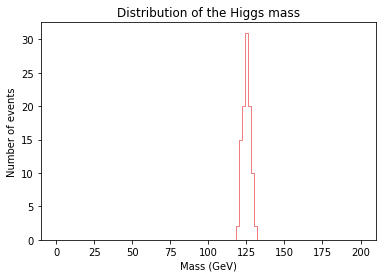

In [29]:
%matplotlib inline 
plt.title("Distribution of the Higgs mass")
n, bins, patches = plt.hist(signal, bins=n_bins, range = (x_min, x_max), color='lightcoral', histtype='step', density=False, log=False)
plt.xlabel("Mass (GeV)")
plt.ylabel("Number of events")

## Generate background sample

`n_bkg_0` events with an exponential distribution. Use [numpy.random.exponential](https://numpy.org/doc/stable/reference/random/generated/numpy.random.exponential.html).

Choose an exponential parameter that populates bins with tens of events for mass of 200 GeV. For example, use `scale=80` in [numpy.random.exponential].

In [32]:
background = np.random.exponential(80, n_bkg_0)
print(len(background) == n_bkg_0)

True


## Plots background distribution
Use [matplotlib.pyplot.hist](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.hist.html)

Useful options:
- _bins=n_ : fix number of bins to _n_
- _hist=options_ : for example _hist='step'_ to show empty histogram
- _range=(min,max)_ : fix the boundaries of data in histogram. 
  - **NB**: this is different than using _xlim(min,max)_ which is only for visualization


Text(0, 0.5, 'Number of events')

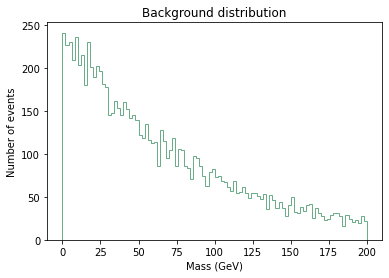

In [33]:
plt.title("Background distribution")
n, bins, patches = plt.hist(background, bins=n_bins, range = (x_min, x_max), color='seagreen', alpha=0.7, histtype = 'step', density=False, log=False)
plt.xlabel("Mass (GeV)")
plt.ylabel("Number of events")

## Stack signal and background data in the same histogram

If you have two data arrays `signal` and `background`, the following can stack `signal` on top of the `background`

```python
plt.hist((background, signal), bins=n_bins, label=('backgroud', 'signal'),
         color=('red', 'blue'), stacked=True, 
         histtype='step', range=(x_min, x_max))
```

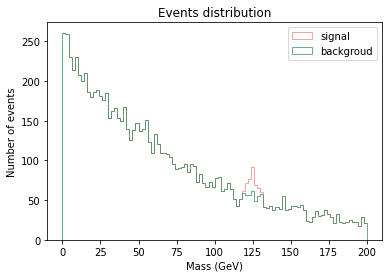

In [27]:
plt.title("Events distribution")
plt.xlabel("Mass (GeV)")
plt.ylabel("Number of events")
plt.hist((background, signal), bins=n_bins, label=('backgroud', 'signal'), color=('seagreen', 'lightcoral'), alpha=0.7, stacked=True, histtype='step', range=(x_min, x_max))
plt.legend()

## Merge signal and background samples

The data collected in an experiment contains both signal and background. Two samples separately stored in NumPy arrays can be merged with [numpy.concatenate](https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html) as follows:

```python
data = np.concatenate((a,b))
```
with the first positional argument of the function being a tuple of numpy arrays.

In [36]:
data = np.concatenate((signal,background))

## Binned data

The data sample so far is unbinned: we have a number of signal and background events. 

Now we can create a binned version to be fitted. This is achieved with the `pyplot.hist` function which, as we saw, returns a list of counts for each bin and the bin boundaries
```python
binned_data, bins, _ = plt.hist(data, bins=n_bins, label='all data', color='black', histtype='step', range=(x_min, x_max))
```

Plot the merged data and make sure it is indeed the sum of the two sub-samples.

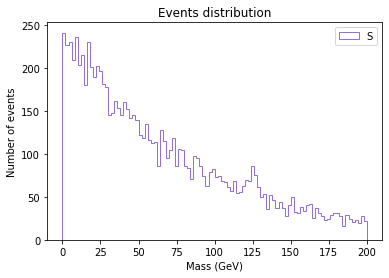

In [45]:
plt.title("Events distribution")
plt.xlabel("Mass (GeV)")
plt.ylabel("Number of events")
binned_data, bins, _ = plt.hist(data, bins=n_bins, label='all data', color='mediumpurple', histtype='step', range=(x_min, x_max))
plt.legend("Signal + Background")

## `bins` list

The list `bins` contains `n_bins + 1` values. These are run from the edge of the first bin to the edge of the last bin. Verify this.

In [46]:
print("Length of array bins: {0}, first bin: {1}, last bin: {2}".format(len(bins),bins[0],bins[-1]))

Length of array bins: 101, first bin: 0.0, last bin: 200.0


## Center of bins (data along $x$ axis)

Using a comprehension, prepare a list `center_bins` from `bins` with length of `n_bins` which contains the center of each bin of the histogram. Check your result.

In [52]:
center_bins = list(bins + bin_width/2)
center_bins.pop()
center_bins = np.array(center_bins)
print(type(center_bins), center_bins)

<class 'numpy.ndarray'> [  1.   3.   5.   7.   9.  11.  13.  15.  17.  19.  21.  23.  25.  27.
  29.  31.  33.  35.  37.  39.  41.  43.  45.  47.  49.  51.  53.  55.
  57.  59.  61.  63.  65.  67.  69.  71.  73.  75.  77.  79.  81.  83.
  85.  87.  89.  91.  93.  95.  97.  99. 101. 103. 105. 107. 109. 111.
 113. 115. 117. 119. 121. 123. 125. 127. 129. 131. 133. 135. 137. 139.
 141. 143. 145. 147. 149. 151. 153. 155. 157. 159. 161. 163. 165. 167.
 169. 171. 173. 175. 177. 179. 181. 183. 185. 187. 189. 191. 193. 195.
 197. 199.]


## Bin count (data along $y$ axis)

Verify that the list `binned data` has length `n_bins`.

In [53]:
print(len(binned_data) == n_bins)

True


## Fitting the histogram

We want to fit the binned data (`binned_data` as a function of `center_bins`) using the [optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) function.

The fit model has to be the sum of a Gaussian and an exponential.

Define three functions with proper arguments
1. `sig(x, Norm, mean, width)` for the signal Gaussian
2. `bkg(x, Norm, alpha)` for the background exponential
3. `total(x, NormSig, mean, width, NormBkg, alpha)` sum of signal and background

There is a total of 5 parameters to be fitted from the simulated data.

In [55]:
def sig(x, Norm = n_sig_0, mean = m_sig, width = w_sig):
  return Norm*np.exp(-(x-mean)*(x-mean)/(2*width*width))
                     
def bkg(x, Norm = n_bkg_0, alpha = 80):
  return Norm*np.exp(-x/alpha)

def total(x, NormSig = n_sig_0, mean = m_sig, width = w_sig, NormBkg = n_bkg_0, alpha = 80):
  return sig(x, NormSig, mean, width) + bkg(x, NormBkg, alpha)

## Plot fit function

As a sanity check, plot the 3 functions and make sure they are implemented correctly.

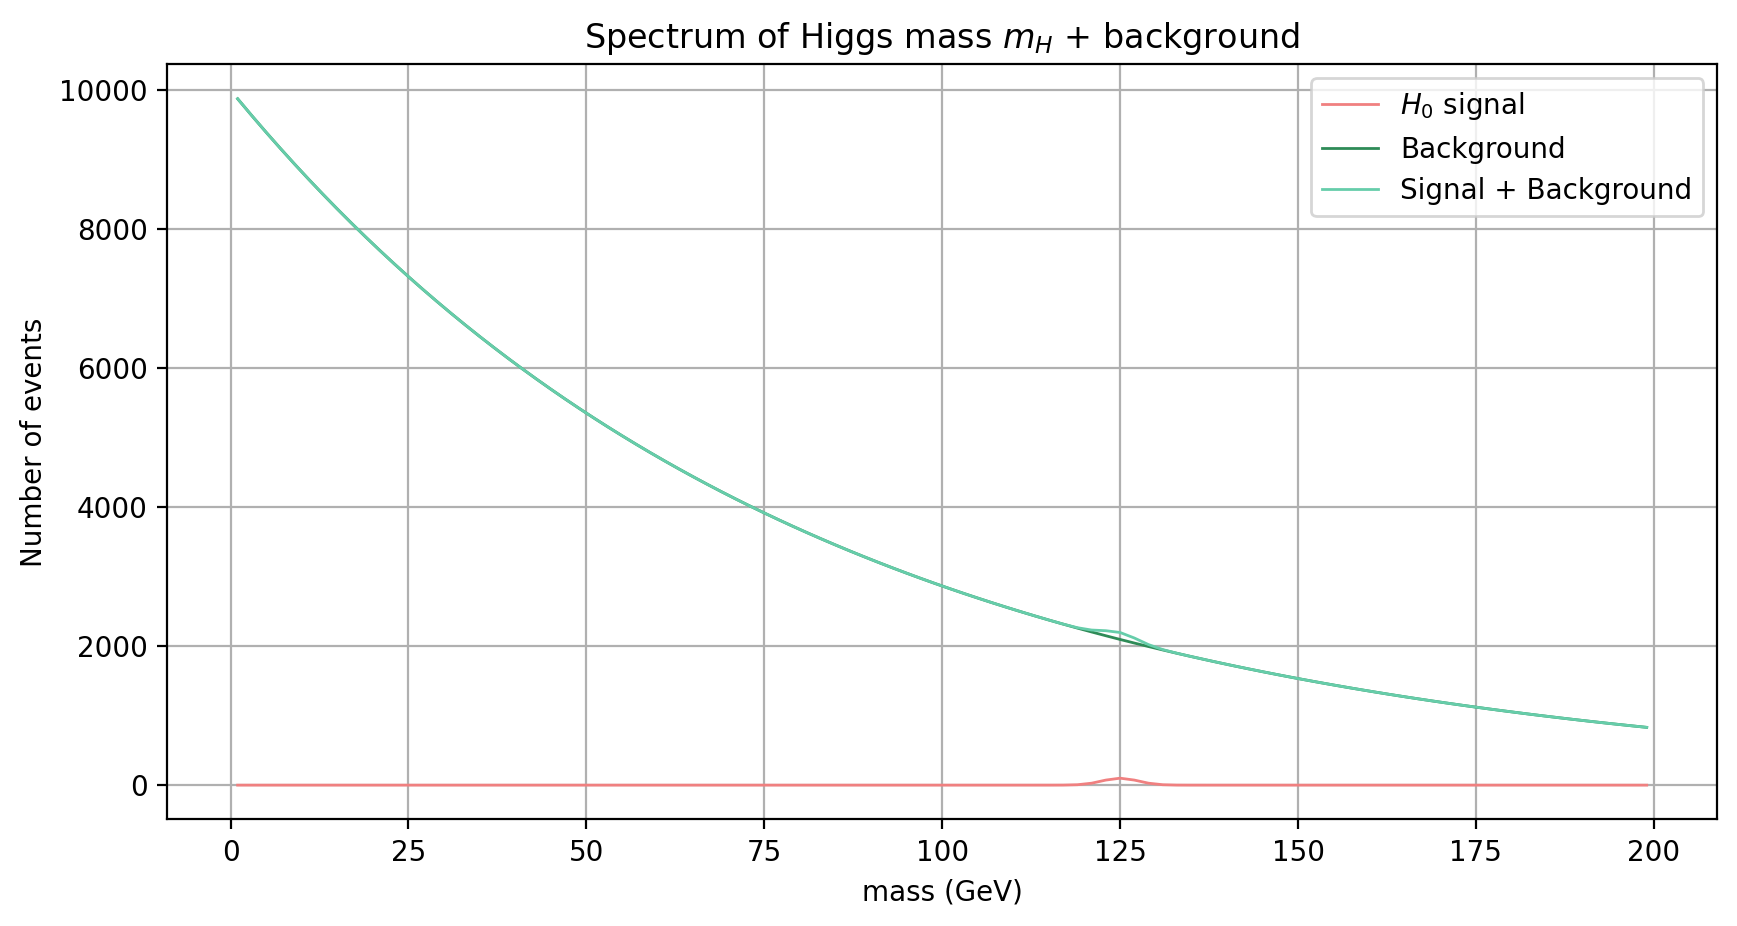

In [105]:
%matplotlib inline

plt.figure(figsize=(10,5),dpi=200)
plt.plot(center_bins, sig(center_bins), lw=1, color='lightcoral', label='$H_0$ signal')
plt.plot(center_bins, bkg(center_bins), lw=1, color='seagreen', label='Background')
plt.plot(center_bins, total(center_bins), lw=1, color='mediumaquamarine', label='Signal + Background')
plt.xlabel('mass (GeV)')
plt.ylabel('Number of events')
plt.title('Spectrum of Higgs mass $m_H$ $+$ background')
plt.legend()
plt.grid()

## Initial conditions for the fit

It is always a good practice to provide some initial values for the parameters to be fitted, especially in a case like this one where there are 5 parameters and the data varies a lot across the spectrum. Initial values are passed to [optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) with the argument `p0`:
```python
pars, pars_cov = opt.curve_fit(..., p0=[500, m_sig, w_sig, 1000, alpha])
```

Recall that `pars` is the list of fitted parameters (in the order they appear in the definition of the fit function) and `pars_cov` is their covariance matrix that can be used to compute the uncertainty on each fitted parameter.

In [106]:
pars, pars_cov = opt.curve_fit(total, center_bins, binned_data, p0=[n_sig_0, m_sig, w_sig, n_bkg_0, 80])

## Fitted parameters
- Print the parameters
- Print the covariance matrix

Are the fitted values close to the generated values?

In [151]:
names = ['N_{signal}','m_{H}', '\sigma_{m_H}', 'N_{background}', '\u03B1']
for index, value in enumerate(pars):
    txt = '\mathrm{{{2}}} = {0:.3f} \pm {{{1:.3f}}}'.format(value, pars_cov[index, index], names[index])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Plot the histogram and fit

- Plot the data histogram
- Overlay the fitted function (total) with the fitted parameters
- Overlay the background function with the fitted parameters
- Print the fitted parameters with proper legend on the screen

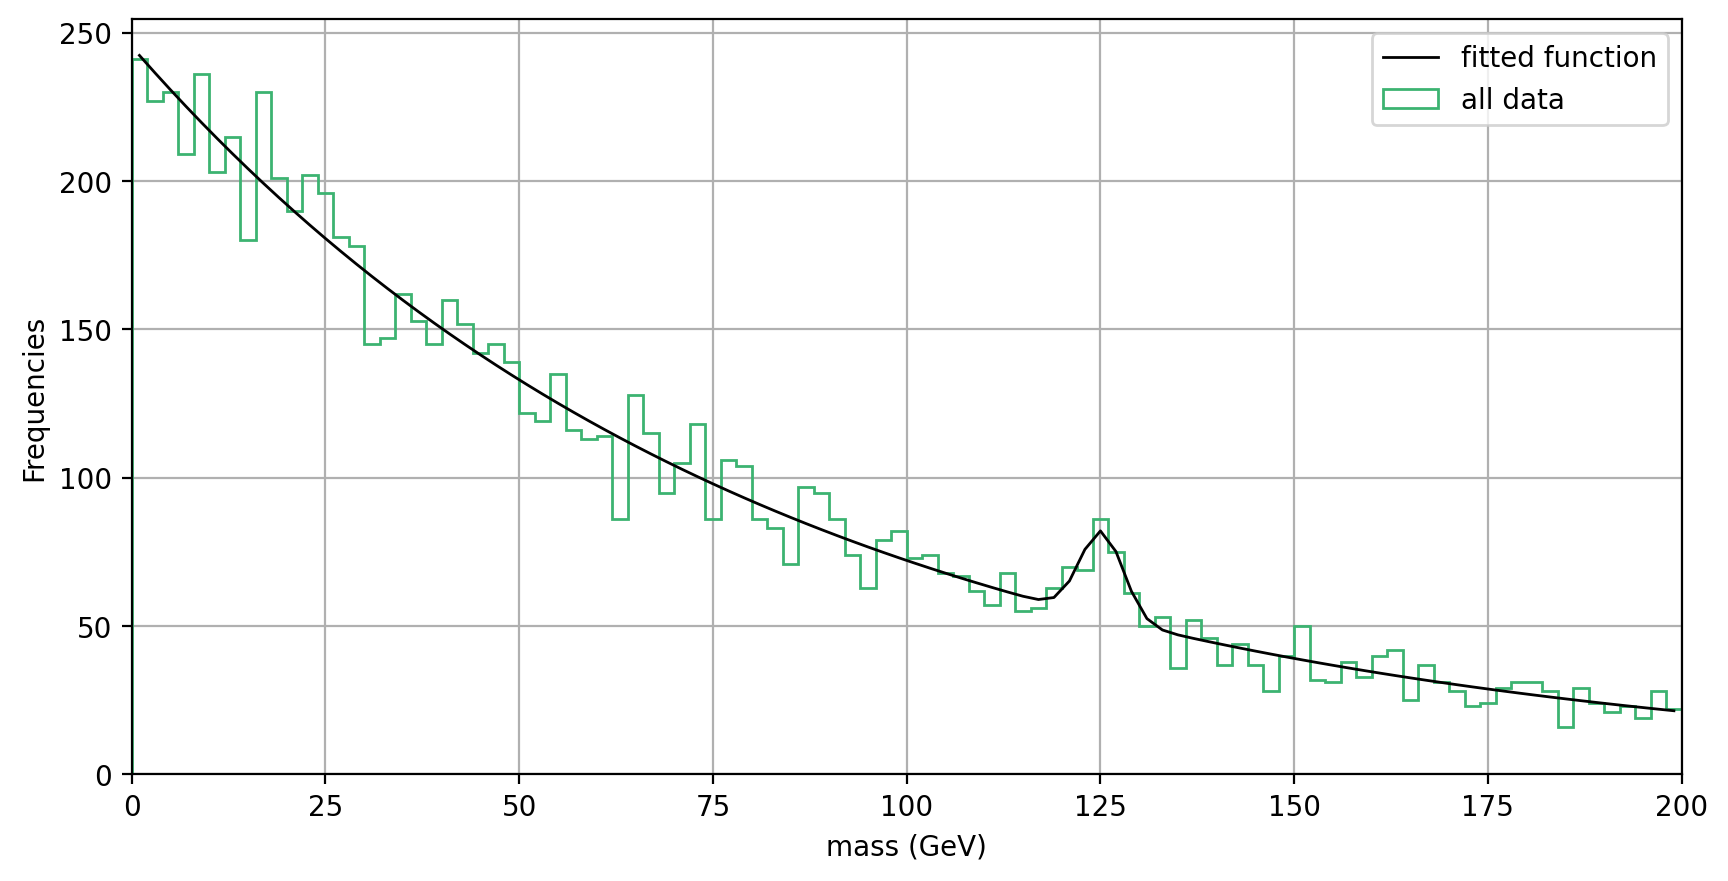

In [148]:
def fitted_total_function(x):
    return total(x, pars[0], pars[1], pars[2], pars[3], pars[4])

plt.figure(figsize=(10,5),dpi=200)
plt.hist(data, bins=n_bins, label='all data', color='mediumseagreen', histtype='step', lw=1, range=(x_min, x_max))
plt.plot(center_bins, fitted_total_function(center_bins), label='fitted function', lw=1, color='k')
plt.xlim(x_min,x_max)
plt.xlabel('mass (GeV)')
plt.ylabel('Frequencies')
plt.grid()
plt.legend()

# Signal Significance

The signal significance is defined as

$$
S/\sqrt{B}\,,
$$

where

$$
\begin{align}
S &= \int_a^b sig(m)\, dm\\
B &= \int_a^b bkg(m)\, dm
\end{align}
$$

with $a = m_{\rm fitted} - 3\sigma_{\rm fitted}$ and $b = m_{\rm fitted} + 3\sigma_{\rm fitted}$.

Use [scipy.integrate.quad](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html) to compute the integral.

The result of a call to `scipy.integrate.quad` is a list with two elements:
1. the value of the integral
1. its uncertainty

## Compute $S$

In [157]:
sigma_m = pars_cov[1,1]
fitted_m = pars[1]

def s(x):
  return sig(x, Norm = pars[0], mean = fitted_m, width = sigma_m)

S_value, S_error = integrate.quad(s, fitted_m-3*sigma_m, fitted_m+3*sigma_m)

display(Math('\mathrm{{{0}}} = {1:f} \pm {{{2:f}}}'.format('S', S_value, S_error)))

<IPython.core.display.Math object>

## Compute $B$

In [158]:
def b(x):
  return bkg(x, Norm = pars[3], alpha = pars[4])

B_value, B_error = integrate.quad(b, fitted_m-3*sigma_m, fitted_m+3*sigma_m)

display(Math('\mathrm{{{0}}} = {1:f} \pm {{{2:f}}}'.format('B', B_value, B_error)))

<IPython.core.display.Math object>

## Compute significance and print the result

In [165]:
significance = S_value/np.sqrt(B_value)
print("Significance of the signal:")
display(Math('\mathrm{{{0}}} = {1}'.format('Significance', significance)))

if(significance>=5):
    print("WE'VE FOUND A NEW PARTICLE! :)")
else:
    pass

Significance of the signal:


<IPython.core.display.Math object>

# Exercise 1

1. Fix the number of background events $N_B = 10000$ and vary the number of signal events $N_S$ in 
 `[10, 50, 100, 500, 1000]`
  - Plot the signficance as a function of $N_S$
  - You can now change $N_B$ and generate the same plot and show the data for different values of $N_B$
  - How does the significance depend on $N_S$ and $N_B$?

#### Setup

In [187]:
n_bkg = int(1e4)
n_sig_array = [10, 50, 100, 500, 1000]

# generation of background events
background = np.random.exponential(80, n_bkg)

# preset of significances list
significances = []

#### Functions definition
- `sig`, `bkg` and `total` functions are models of signals
- `data_generation` generates undistinguishable data of signal and background
- `Significance` gives the significance and requires fitted values and array of their covariances

In [185]:
# signal model
def sig(x, NormSig, mean, width):
  return NormSig*np.exp(-(x-mean)*(x-mean)/(2*width*width))

# background model
def bkg(x, NormBkg, alpha):
  return NormBkg*np.exp(-x/alpha)

# superposition of signal and background
def total(x, n_sig, m_sig, w_sig, n_bkg, alpha_):
  return sig(x, NormSig = n_sig, mean = m_sig, width = w_sig) + bkg(x, NormBkg = n_bkg, alpha = alpha_)

# generates ndarray of data
def data_generation(n_sig):
  # signal generation
  signal = [np.random.normal(m_sig, w_sig) for i in range(n_sig)]
  # data
  data = np.concatenate((signal,background))
  # binned_data for fit
  binned_data, bins, _ = plt.hist(data, bins=n_bins, label='all data', color='black', histtype='step', range=(x_min, x_max))
  
  return binned_data, bins

def Significance(values, covariances):
  def fitted_signal(x):
    return sig(x, NormSig = values[0], mean = values[1], width = values[2])
  
  def fitted_background(x):
    return bkg(x, NormBkg = values[3], alpha = values[4])
  
  S_val, _ = integrate.quad(fitted_signal, values[1]-3*covariances[1,1], fitted_m+3*covariances[1,1])

  B_val, _ = integrate.quad(fitted_background, values[1]-3*covariances[1,1], fitted_m+3*covariances[1,1])
  
  return S_val/np.sqrt(B_val)

#### Implementation
A loop over the numbers of Higgs events to generate data, fit them and append ti array `significances` the value of significance. We can see that it is very large for a fraction of Higgs events $f \ge 0.001$

Significances = [0.0, 0.0, 1.1470970812472803, nan, 20.395563723867575]


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/var/folders/dr/0kfsv0410yqcv4gkk8gg9vbc0000gn/T/ipykernel_1231/1443366521.py:7: RuntimeWarning: overflow encountered in exp
  return NormBkg*np.exp(-x/alpha)
/var/folders/dr/0kfsv0410yqcv4gkk8gg9vbc0000gn/T/ipykernel_1231/1443366521.py:7: RuntimeWarning: overflow encountered in exp
  return NormBkg*np.exp(-x/alpha)
/var/folders/dr/0kfsv0410yqcv4gkk8gg9vbc0000gn/T/ipykernel_1231/1443366521.py:35: RuntimeWarning: invalid value encountered in sqrt
  return S_val/np.sqrt(B_val)


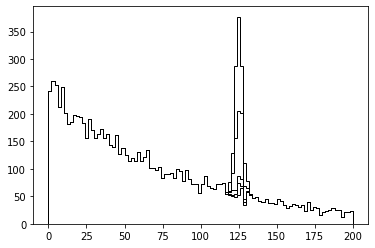

In [192]:
# loop over differents number of Higgs events
for n_sig in n_sig_array:

  # events generation
  binned_data, bins = data_generation(n_sig)
  
  # x-axis set
  center_bins = list(bins + bin_width/2)
  center_bins.pop()
  center_bins = np.array(center_bins)
  
  # parameter extimation
  pars, pars_cov = opt.curve_fit(total, center_bins, binned_data, p0=[n_sig, m_sig, w_sig, n_bkg, 80])

  significances.append(Significance(pars, pars_cov))
  
print('Significances =', significances)
significances.clear()

# Exercise 2

2. Fix $N_B = 10000$ and $N_S = 200$. Vary the mass width in `[0.01, 0.2, 0.05, 0.10, 0.20, 0.50]`
  - Plot the significance as a function of the mass width 
  - Which mass width provide the best signal significance?

#### Setup

In [195]:
n_bkg = int(1e4)
n_sig_array = 200

m_sig = 125 # GeV
w_sig = [0.01, 0.2, 0.05, 0.10, 0.20, 0.50] # in %
w_sig *= m_sig

# generation of background events
background = np.random.exponential(80, n_bkg)

# list of significances
significances = []

# Exercise 3


3. Fix $N_B = 10000$ and $N_S = 200$ and repeat the experiments 1000 times
  - For each experiment generate the number of signal and background events from a Poisson distribution
    - mean of signal events: 200
    - mean of background events: 10000
  - Compute the significance for each experiment
  - Plot the distribution of significance for all experiments
  - Plot the distribution of $m_{fitted} - m_H$ for all experiments
  - Fit to a Gaussian and print the fitted $\mu$ and $\sigma$